## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

#### Briefly state how you computed the camera matrix and distortion coefficients.
The code for computing the camera matrix and distortion coefficients is in the function `cal_camera` of the file `camera.py`. This is done by using all the `calibration*.jpg` files (6 x 9 chessboard images) in the `camera_cal` folder in the following manner:
- Keep an array of object points (3D) and image points (2D)
- Convert each file to grayscale
- Find the chessboard corners using `cv2.findChessboardCorners` and append them to our image points array
- Get the camera matrix and distortion coefficients using `cv2.calibrateCamera`

In [1]:
import cv2
import glob
import os

from matplotlib import pyplot as plt
from scipy.misc import imread, imsave
from threshold import threshold_image
from camera import cal_camera, warper, rows, cols, c_src, c_dst, offset
from lanes import overlay_lanes

# 1. Compute the camera calibration using chessboard images
ret, mtx, dist, rvecs, tvecs = cal_camera()

Starting camera calibration!
Finished camera calibration!


## Apply a distortion correction to raw images
#### Provide an example of a distortion corrected calibration image. More examples of undistorted images can be found at `output_images/*_undist.jpg`

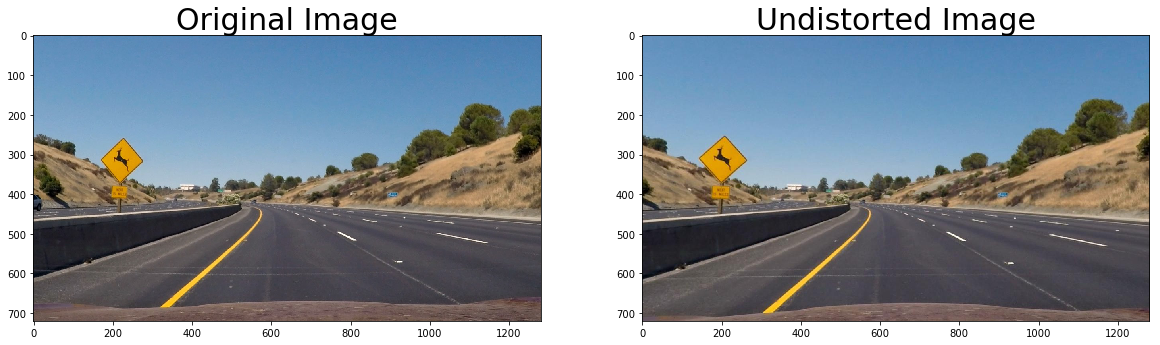

In [7]:
%matplotlib inline

# Remove any previously undistorted images
filelist = [ f for f in os.listdir('output_images/') if f.find('_undist') != -1]
for f in filelist:
    os.remove('output_images/' + f)

# Make a list of raw images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort images
for fname in images:
    # Read raw image
    img = imread(fname)

    # Get image path and name details
    basedir, basename = os.path.split(fname)
    root, ext = os.path.splitext(basename)

    # Undistort image
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Save undistorted image
    imsave('output_images/' + root + '_undist.jpg', dst)

# Display an example distorted and an undistorted image
img = imread('test_images/test2.jpg')
dst = imread('output_images/test2_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.
#### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result. More examples of binary thresholded images can be found at `output_images/*_thresh.jpg`
The code for creating a thresholded binary image is in the file `threshold.py`. This file contains 4 thresholding functions and one wrapper function to simplify the thresholding process:
- `abs_sobel_thresh:` computes the sobel function and applies a threshold 
- `mag_thresh:` computes the magnitude of the gradient and applies a threshold
- `dir_threshold:` computes the direction of the gradient and applies a threshold
- `color_threshold:` transforms the image to HLS and applies a threshold to the S channel
- `threshold_image:` calls all of the thresholding functions above and combines the thresholds using default parameters. These parameters were found empirically during the advanced lane finding quizes.
-- Sobel kernel size of 15 (this is used across all functions)
-- Sobel min threshold of 20
-- Sobel max threshold of 100
-- Magnitude min threshold of 30
-- Magnitude max threshold of 100
-- Direction min threshold of 0.7
-- Direction max threshold of 1.2
-- Color min threshold of 170
-- Color max threshold of 255

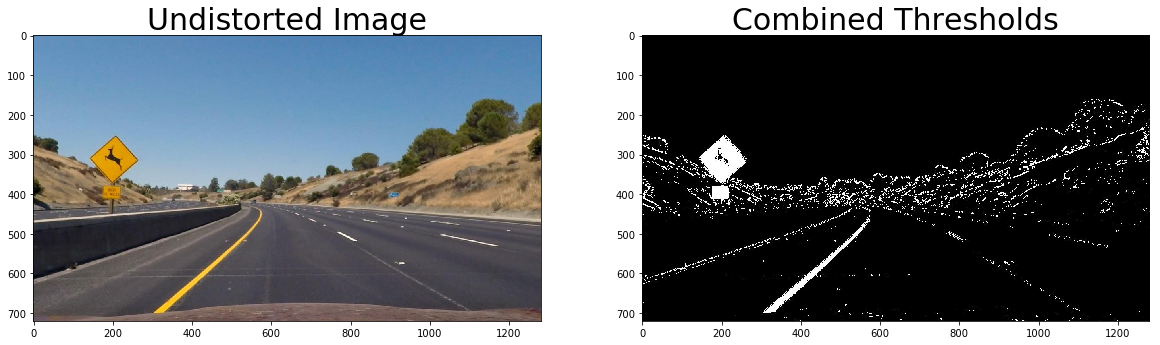

In [8]:
# Remove any previously thresholded images
filelist = [ f for f in os.listdir('output_images/') if f.find('_thresh') != -1]
for f in filelist:
    os.remove('output_images/' + f)

# Make a list of raw images
images = glob.glob('output_images/*_undist.jpg')

# Step through the list and apply thresholds
for fname in images:
    # Read raw image
    img = imread(fname)

    # Get image path and name details
    basedir, basename = os.path.split(fname)
    root, ext = os.path.splitext(basename)
    root = root[:root.rfind('_')]

    # Threshold image
    combined = threshold_image(img)

    # Save thresholded image
    imsave('output_images/' + root + '_thresh.jpg', combined)

# Display an example undistorted and a thresholded  image
img = imread('output_images/test2_undist.jpg')
dst = imread('output_images/test2_thresh.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=30)

## Apply a perspective transform to rectify binary image ("birds-eye view").
#### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image. More examples of perspective transformed images can be found at `output_images/*_trans.jpg`
The code for applying a perspective transform, including the definition of source and destination points is in the file `camera.py`. The function `warper` uses the following functions:
- `cv2.getPerspectiveTransform:` calculates the perspective transform matrix based on two sets of four points (source and destination.)
- `cv2.warpPerspective:` uses the matrix calculated above and applies a perspective transformation to an image.

The source and destination points have been plotted below for easier visualization.

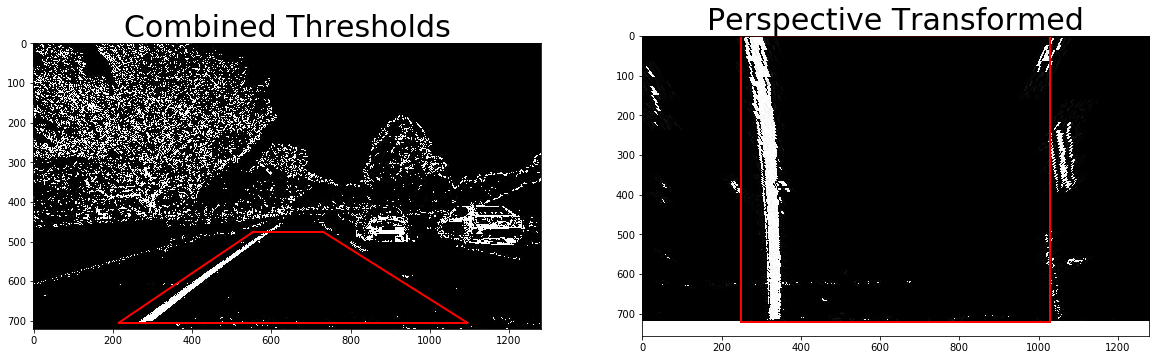

In [9]:
# Remove any previously perspective transformed images
filelist = [ f for f in os.listdir('output_images/') if f.find('_trans') != -1]
for f in filelist:
    os.remove('output_images/' + f)

# Make a list of thresholded images
images = glob.glob('output_images/*_thresh.jpg')

# Step through the list and apply perspective transform
for fname in images:
    # Read raw image
    img = imread(fname)

    # Get image path and name details
    basedir, basename = os.path.split(fname)
    root, ext = os.path.splitext(basename)
    root = root[:root.rfind('_')]

    # Apply perspective transform
    warped = warper(img, c_src, c_dst)

    # Save perspective transformed image
    imsave('output_images/' + root + '_trans.jpg', warped)

## Display an example undistorted and a thresholded  image
dst = imread('output_images/test2_trans.jpg')
image = imread('output_images/test2_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Combined Thresholds', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Perspective Transformed', fontsize=30)
# Plot source points
ax1.plot([555, 730], [475, 475], color='r', linestyle='-', linewidth=2)
ax1.plot([730, 1095], [475, 705], color='r', linestyle='-', linewidth=2)
ax1.plot([1095, 215], [705, 705], color='r', linestyle='-', linewidth=2)
ax1.plot([215, 555], [705, 475], color='r', linestyle='-', linewidth=2)
# Plot destination points
ax2.plot([offset, cols-offset], [0, 0], color='r', linestyle='-', linewidth=2)
ax2.plot([cols-offset, cols-offset], [0, rows], color='r', linestyle='-', linewidth=2)
ax2.plot([cols-offset, offset], [rows, rows], color='r', linestyle='-', linewidth=2)
ax2.plot([offset, offset], [rows, 0], color='r', linestyle='-', linewidth=2)

## Detect lane pixels and fit to find the lane boundary.
#### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial
The code for detecting lane pixels and fitting a second order polynomial is in the `overlay_lanes` function of the file `lanes.py` (lines 8 to 104.) The general algorithm used is as follows:
- Calculate histogram of the bottom half of the image
- Split histogram into two and find left and right peaks
- Split image into 10 horizontal bands
- Using the left and right peaks as starting point:
-- Move upwards band height pixels
-- Get all non-zero pixels inside the window
-- Calculate the centroid of the window
-- Move upwards 'band height' pixels centered at x on the centroid
-- Repeat until we reach the top of the image
-- Add the top pixels to ensure all fitted lines do not cut before the top
## Determine the curvature of the lane and vehicle position with respect to center.
#### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
The code for determining the curvature of the lane and vehicle position with respect to center is in the `overlay_lanes` function of the file `lanes.py` (lines 130 to 159.) The curvature code is directly borrowed from the *Measuring Curvature* tutorial. The general algorithm used for calculating the position of the car is as follows:
- Calculate the center of the lane (`lane_center`.)
- Assuming the camera is positioned exactly in the middle of the car behind the windshield, we can assume the center is at 1280/2 (half the width of the image) so the position becomes `(1280/2 - lane_center).`
## Warp the detected lane boundaries back onto the original image.
The code for warping the detected lane boundaries back onto the original image is in the `overlay_lanes` function of the file `lanes.py` (lines 106 to 125.) The curvature code is directly borrowed from the *Tips and Tricks for the Project* tutorial.
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
#### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly. More examples of lane boundary overplotted images images can be found at `output_images/*_final.jpg`

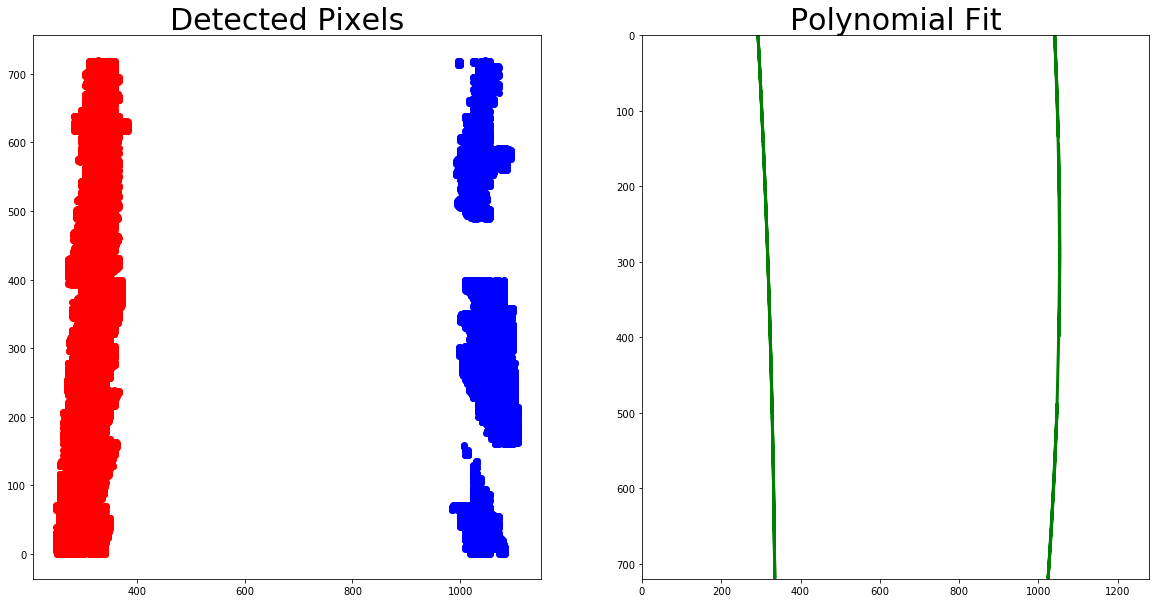

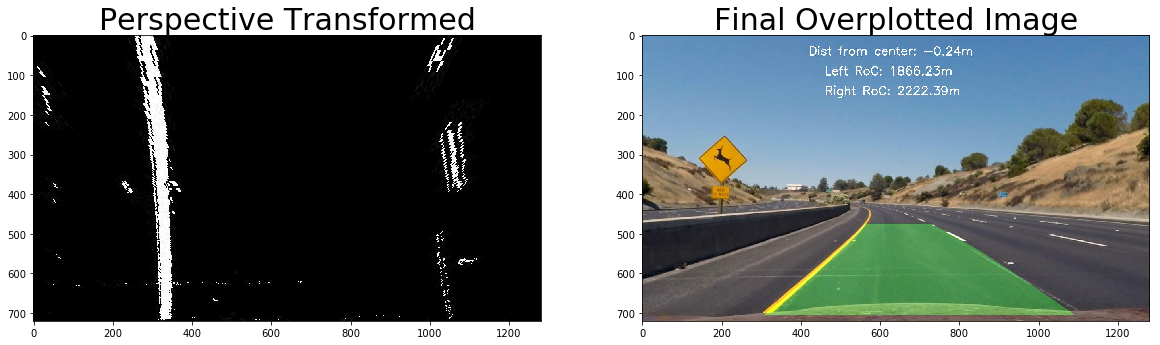

In [10]:
# Remove any previously lane boundary overplotted images
filelist = [ f for f in os.listdir('output_images/') if f.find('_final') != -1]
for f in filelist:
    os.remove('output_images/' + f)

# Make a list of perspective transformed images
t_images = glob.glob('output_images/*_trans.jpg')
# Make a list of undistorted images
u_images = glob.glob('output_images/*_undist.jpg')

# Step through the list and find lane pixels
for tname, fname in zip(t_images, u_images):
    # Read raw images
    t_img = imread(tname)
    u_img = imread(fname)
    # Apply grayscale thresholding to convert perspective transformed images to BW with 1 and 0 values only
    (thresh, t_img) = cv2.threshold(t_img, 128, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Get image path and name details
    basedir, basename = os.path.split(tname)
    root, ext = os.path.splitext(basename)
    root = root[:root.rfind('_')]

    # Find lane pixels and overlay lane boundary and related info
    final = overlay_lanes(t_img, u_img)

    # Save perspective transformed image
    imsave('output_images/' + root + '_final.jpg', final)

# Display an example perspective transformed and a lane boundary overplotted  image
img = imread('output_images/test2_trans.jpg')
u_img = imread('output_images/test2_undist.jpg')
dst = imread('output_images/test2_final.jpg')

# Display pixels and polynomial fit
overlay_lanes(img, u_img, True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Perspective Transformed', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Final Overplotted Image', fontsize=30)

## Process video using image processing pipeline
#### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)
Output video file is `project_video_output.mp4`, but can also be found at: https://youtu.be/qSE2yLR_iG0

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define image processing pipeline
def process_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    thresh = threshold_image(undist)
    trans = warper(thresh, c_src, c_dst)
    result = overlay_lanes(trans, undist)
    return result

# Hook up video to image processing pipeline
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:35<00:00,  3.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 35s


# Discussion
#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
One of the biggest issues that I faced working with the source and destination points for perspective transform. Initially I (incorrectly) thought we had to detect these points for each individual image so I tried estimating the lane lines using the HoughLinesP function and then applying some offsets on each side. This didn't work too well and I spent quite a bit of time working on this problem until I realized the source and destination points only needed to be set once at the start and could be done manually.

The pipeline will most likely fail in situations where there's a vertical split of colors on the road like in the challenge video or major fluctuations in light conditions and/or shadows or very curvy roads as in the harder challenge video. Some ways to make the pipeline more robust is to implement recovery when tracking is lost, smoothing the measurements across multiple frames and some sort of dynamic image processing system that has settings for a few normal lighting conditions (e.g. dusk, clear day, bright sunny day, etc) and have the system run lane finding in parallel on each then choosing the one that gets the best and most logical lane prediction.